# Unsupervised LATAQ pipeline with TRVAE

In [1]:
import os

import scanpy as sc
import torch
# import scarches as sca
import lataq
from lataq.models import TRANVAE
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [2]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting. The best earlystopping criteria is the 'val_unweighted_loss' for TRVAE.

In [3]:
DATA_FILENAME = os.path.expanduser("~/data/misc/pancreas_normalized.h5ad")

condition_key = 'study'
cell_type_keys = ['cell_type']
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']


trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

## Split Data into reference dataset and query dataset

In [4]:
adata_all = sc.read(DATA_FILENAME)

This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss. However, when using trVAE with MSE loss normalized data is necessary in adata.X

In [5]:
adata = adata_all.raw.to_adata()
# adata.obs['cell_types'] = adata.obs['cell_type']

adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_conditions = source_adata.obs[condition_key].unique().tolist()

In [6]:
source_adata

View of AnnData object with n_obs × n_vars = 10294 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [7]:
target_adata

View of AnnData object with n_obs × n_vars = 5387 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Create TRVAE model and train it on reference dataset

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [8]:
from lataq.models import TRANVAE

In [9]:
trvae = lataq.models.TRANVAE(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_keys,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 3
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 3
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [10]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs
)

/home/icb/amirali.moinfar/miniconda3/envs/lataq/lib/python3.8/site-packages/scarches/trainers/trvae/_utils.py:164: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['trvae_size_factors'] = size_factors


loaders init
loaders init done
0.20991110801696777


/home/icb/amirali.moinfar/miniconda3/envs/lataq/lib/python3.8/site-packages/scarches/models/trvae/losses.py:60: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/icb/amirali.moinfar/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


 |█-------------------| 8.8%  - val_loss: 570.3393147786 - val_trvae_loss: 569.0486857096 - val_landmark_loss: 1.2906345129 - val_labeled_loss: 1.2906345129
ADJUSTED LR
 |███-----------------| 15.0%  - val_loss: 667.0387742784 - val_trvae_loss: 665.6891208225 - val_landmark_loss: 1.3496524427 - val_labeled_loss: 1.3496524427
ADJUSTED LR
 |███-----------------| 18.6%  - val_loss: 536.6631435818 - val_trvae_loss: 535.2129380968 - val_landmark_loss: 1.4502124389 - val_labeled_loss: 1.4502124389
ADJUSTED LR
 |████----------------| 20.0%  - val_loss: 539.9863450792 - val_trvae_loss: 538.5385199653 - val_landmark_loss: 1.4478227496 - val_labeled_loss: 1.4478227496
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 78


## Create anndata file of latent representation and compute UMAP


In [11]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_keys[0]].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

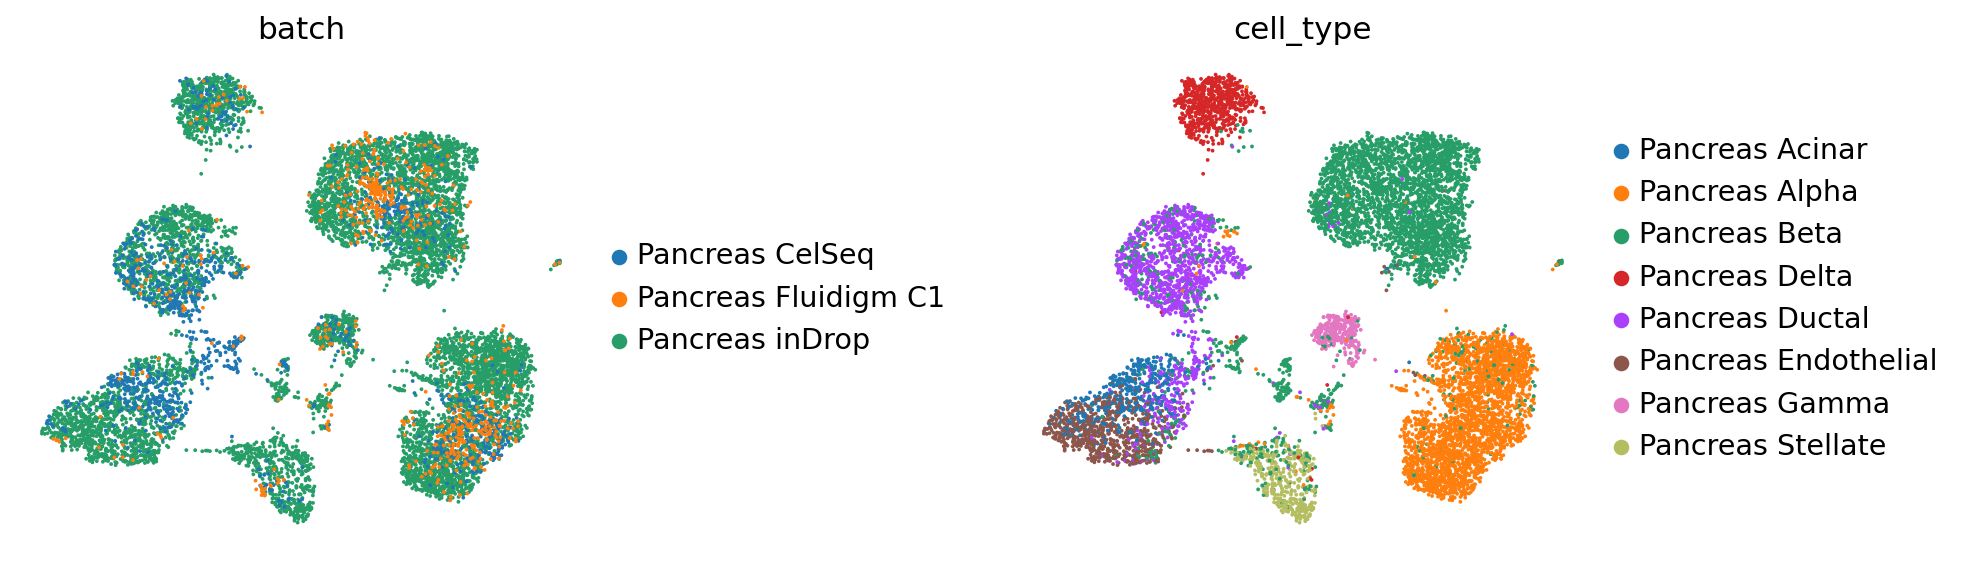

In [12]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [13]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

## Perform surgery on reference model and train on query dataset


In [14]:
target_adata

View of AnnData object with n_obs × n_vars = 5387 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [15]:
new_trvae = lataq.models.TRANVAE.load_query_data(
    adata=target_adata,
    labeled_indices=[],
    reference_model=ref_path)

AnnData object with n_obs × n_vars = 5387 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [16]:
new_trvae.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)


loaders init
loaders init done
0.05483198165893555

Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 12 clusters.
 |████----------------| 22.0%  - val_loss: 1535.8644531250 - val_trvae_loss: 1535.8641601562 - val_landmark_loss: 0.0002904108 - val_unlabeled_loss: 0.2904107809
ADJUSTED LR
 |████----------------| 24.8%  - val_loss: 1560.5377197266 - val_trvae_loss: 1560.5374511719 - val_landmark_loss: 0.0002598252 - val_unlabeled_loss: 0.2598251611
ADJUSTED LR
 |█████---------------| 28.2%  - val_loss: 1545.3661376953 - val_trvae_loss: 1545.3658935547 - val_landmark_loss: 0.0002731705 - val_unlabeled_loss: 0.2731705189
ADJUSTED LR
 |██████--------------| 32.6%  - val_loss: 1551.6833984375 - val_trvae_loss: 1551.6831542969 - val_landmark_loss: 0.0002381921 - val_unlabeled_loss: 0.2381920487
ADJUSTED LR
 |██████--------------| 34.0%  - val_loss: 1560.0717285156 - val_trvae_loss: 1560.0714843750 - val_landmark_loss

In [17]:
adata_target_latent = sc.AnnData(new_trvae.get_latent())
adata_target_latent.obs['cell_type'] = target_adata.obs[cell_type_keys[0]].tolist()
adata_target_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

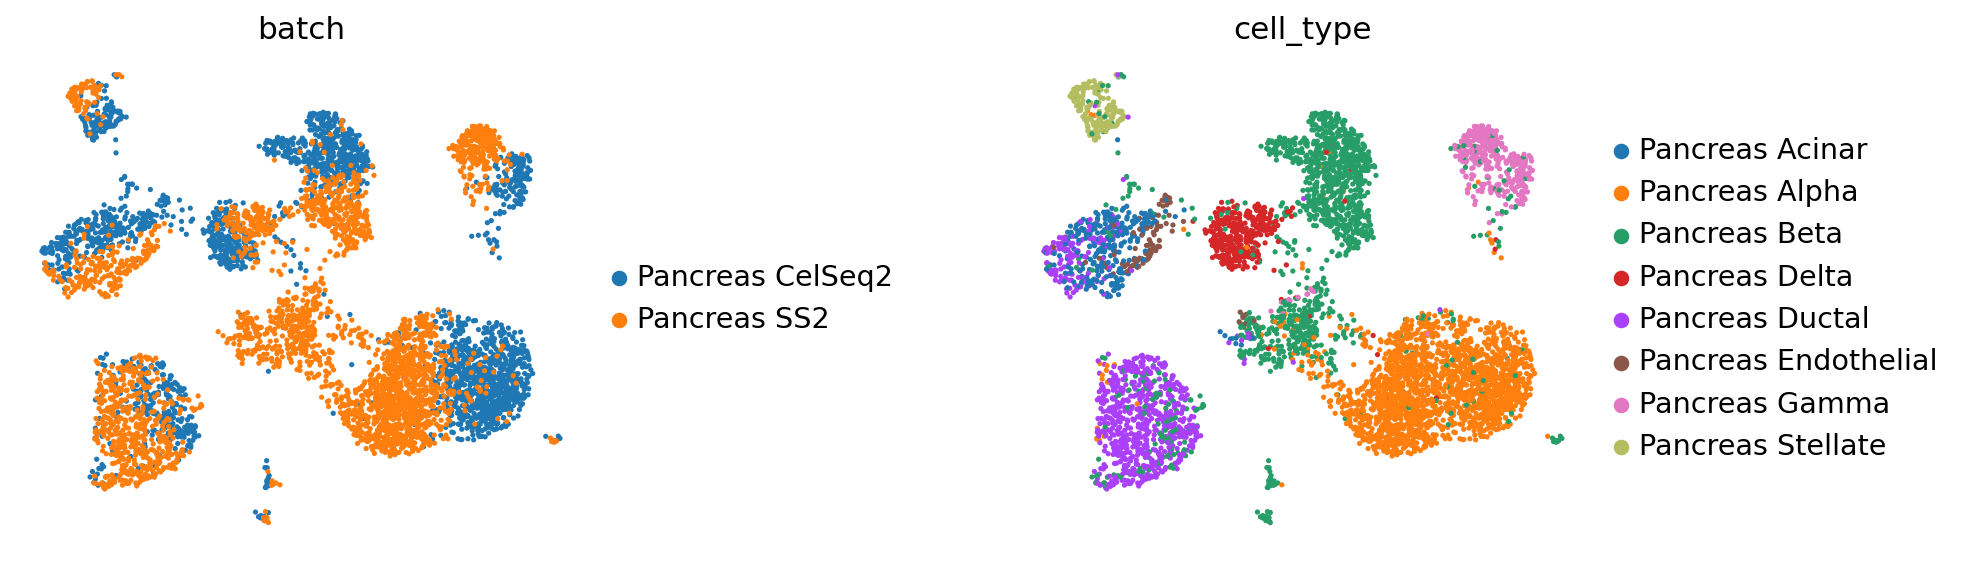

In [18]:
sc.pp.neighbors(adata_target_latent, n_neighbors=8)
sc.tl.leiden(adata_target_latent)
sc.tl.umap(adata_target_latent)
sc.pl.umap(adata_target_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [19]:
results_dict = new_trvae.classify(
    target_adata.X,
    target_adata.obs[condition_key], 
    metric='dist',
    get_prob=False,
    threshold=-np.inf
)

In [20]:
adata_target_latent.obs['pred'] = results_dict['cell_type']['preds']

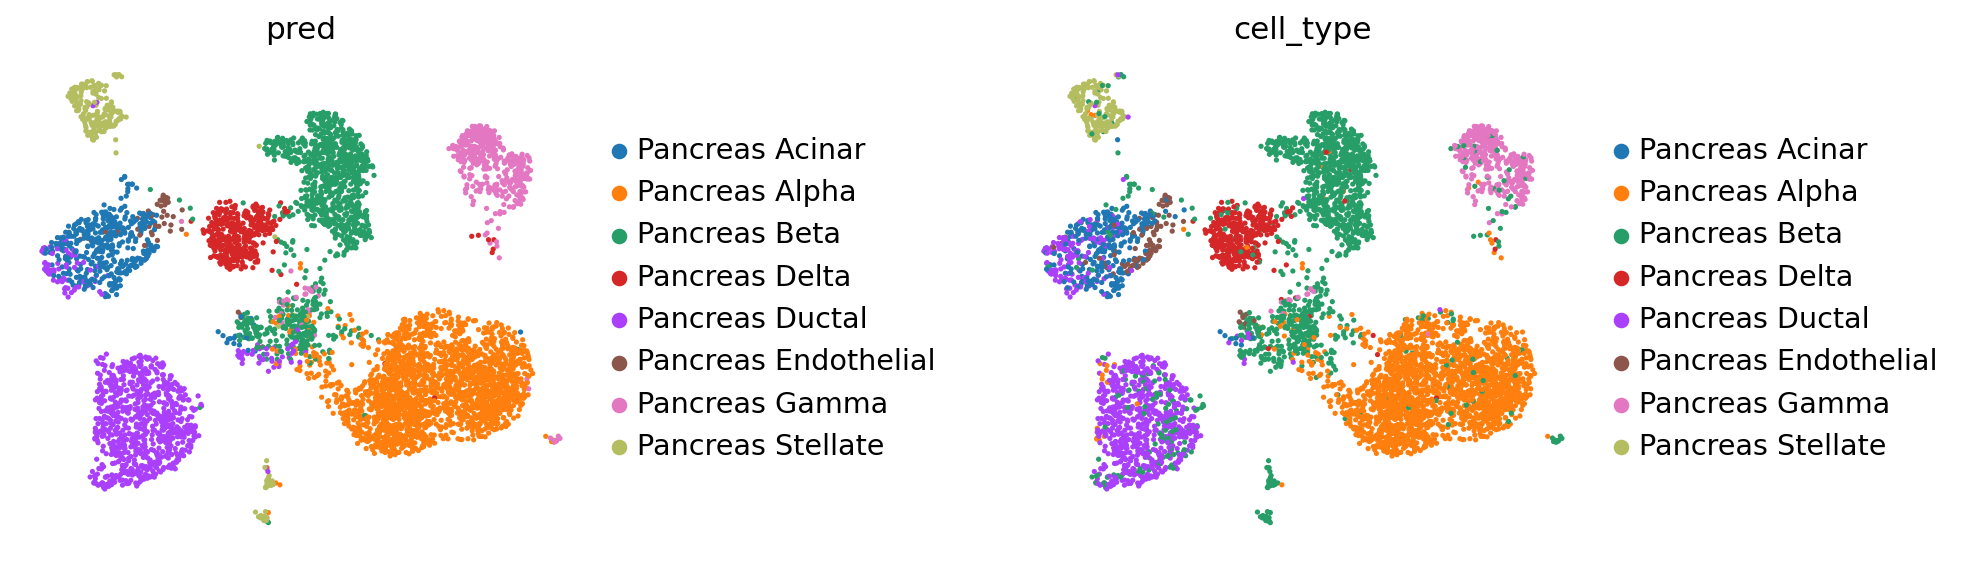

In [21]:
sc.pp.neighbors(adata_target_latent, n_neighbors=8)
sc.tl.leiden(adata_target_latent)
sc.tl.umap(adata_target_latent)
sc.pl.umap(adata_target_latent,
           color=['pred', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )